In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from mmctools.helper_functions import T_to_Tv
from mmctools.similarity import Jimenez_m, Jimenez_h
from mmctools.wrf.landuse import LandUseTable

# WIND Toolkit analysis: quantities of interest
written by Eliot Quon (eliot.quon@nrel.gov)

This notebook uses processed data from `1-process_raw_data.ipynb`.

In [4]:
t0 = pd.to_datetime('2007-01-01')
startanalysis = pd.to_datetime('2011-01-01')  # operation began in Oct 2010, start on a full year

In [5]:
compressed_output = 'data'  # path to data output from initial processing notebook
tsdata = 'WTK_ts.raw.csv.gz'  # time-series data
columndata = 'WTK.interp.csv.gz'  # time-height data

In [6]:
# lat/lon from Google maps
ref_coords = (42.921494, -105.785106)

In [7]:
figdir = 'figures'

if not os.path.isdir(figdir):
    os.makedirs(figdir)

In [8]:
# constants
k = 0.4  # von Karman constant
g = 9.81
Rd = 287 # gas constant for dry air [J kg^-1 K-1]
Cp = 1004. # specific heat at constant pressure for dry air [J kg^-1 K-1]

In [9]:
# landuse information
landuse_idx = 9  # from WRF "clipped_template.nc"
MMINLU = 'USGS'  # from WRF "clipped_template.nc"
landuse_path = '/Users/equon/Downloads/WRF-release_v3-4-1/run/LANDUSE.TBL'

## 1. Load data

In [10]:
%%time
df = pd.read_csv(os.path.join(compressed_output, columndata),
                 parse_dates=['datetime']).set_index(['datetime','height'])
alldatetimes = df.index.get_level_values('datetime')
df = df.loc[(alldatetimes >= startanalysis), :]
times = df.index.get_level_values('datetime').unique()
heights = df.index.get_level_values('height').unique()

# CPU times: user 1.41 s, sys: 136 ms, total: 1.55 s
# Wall time: 1.61 s

CPU times: user 1.46 s, sys: 129 ms, total: 1.59 s
Wall time: 1.63 s


In [11]:
df.head()

pressure  temperature  winddirection  windspeed  \
datetime   height                                                        
2011-01-01 2.0     82498.458594   255.697800            NaN        NaN   
           10.0    82410.199219   255.481125     299.963379   8.313240   
           40.0    82079.226562   255.139313     300.045776   9.454636   
           60.0    81858.578125   254.940948     299.974365   9.753716   
           80.0    81637.929688   254.760895     299.842529   9.961243   

                        theta  
datetime   height              
2011-01-01 2.0     255.717357  
           10.0    255.578895  
           40.0    255.530883  
           60.0    255.528862  
           80.0    255.545586

In [12]:
ts = pd.read_csv(os.path.join(compressed_output, tsdata),
                 parse_dates=['datetime'], index_col=0)
ts = ts.loc[(ts.index >= startanalysis), :]

In [13]:
ts.tail()

,z/L,RH,precipitationrate,GHI,pressure
datetime,,,,,
2013-12-31 19:00:00,0.000000,62.54158,0.0,416.234300,83182.468750
2013-12-31 20:00:00,0.000610,62.24784,0.0,397.488300,83128.453125
2013-12-31 21:00:00,0.001831,65.35982,0.0,306.459230,83132.117188
2013-12-31 22:00:00,0.006714,66.29475,0.0,136.051510,83117.468750
2013-12-31 23:00:00,0.012207,68.06390,0.0,18.150879,83076.265625


In [14]:
ts['RH'].describe()

count    26304.000000
mean        56.314196
std         35.511537
min          0.000000
25%         38.606754
50%         55.262689
75%         71.515779
max        960.074160
Name: RH, dtype: float64

### - figure out landuse information

In [15]:
landuse = LandUseTable(landuse_path)

Reading OLD
Reading USGS
Reading MODIFIED_IGBP_MODIS_NOAH
Reading SiB
Reading LW12
Reading MODIS
Reading SSIB


In [16]:
landuse[MMINLU].loc[landuse_idx]

,albedo,soil_moisture_availability,surface_emissivity,roughness_length,thermal_inertia,snow_cover_effect,surface_heat_capacity,description
season,,,,,,,,
SUMMER,0.2,0.15,0.95,0.06,3,2.14,2.08e+06,Mixed Shrubland/Grassland
WINTER,0.22,0.25,0.93,0.01,4,1.24,2.08e+06,Mixed Shrubland/Grassland


In [17]:
z0_summer = landuse[MMINLU].loc[(landuse_idx,'SUMMER'), 'roughness_length']
z0_winter = landuse[MMINLU].loc[(landuse_idx,'WINTER'), 'roughness_length']

In [18]:
# summer/winter definition from `WRF/phys/module_physics_init.F`
# - is julday ("julian day"?) a misnomer in WRF??
#julday = ts.index.to_julian_date()
julday = ts.index.dayofyear
ts['z0'] = z0_summer
ts.loc[(julday < 105) | (julday > 288), 'z0'] = z0_winter

## 2. Calculate additional atmospheric quantities

In [19]:
Tv = T_to_Tv(df['temperature'], p=0.01*df['pressure'], RH=ts['RH'])

In [20]:
df['density'] = df['pressure'] / Rd / Tv

In [21]:
df['thetav'] = T_to_Tv(df['theta'], p=0.01*df['pressure'], RH=ts['RH'])
df = df.drop(columns=['theta'])

## 3. Calculate u*

### - using WRF similarity function
$U(z) = \frac{u_*}{\kappa} (\log(z/z_0) - \psi_m(z/L) + \psi_m(z_0/L))$

where $\psi_m$ is given in: https://doi.org/10.1175/MWR-D-11-00056.1

#### Notes:
- Similarity functions not validated in complex terrain!
- Terrain can introduce errors in $u_*$ through the vertical momentum fluxes
- Terrain can also introduce errors in the heat flux, in which the correlation between $w'$ and $\theta'$ dictate sign and therefore stability

In [22]:
z = 10.

In [23]:
invL = ts['z/L'] / 2  # measurement height was at 2-m a.g.l.

In [24]:
denom = np.log(z/ts['z0']) - Jimenez_m(z*invL) + Jimenez_m(ts['z0']*invL)

In [25]:
U_at_z = df['windspeed'].xs(z,level='height')

In [26]:
ts['u*'] = k * U_at_z / denom

In [27]:
ts['u*'].describe()

count    26304.000000
mean         0.364613
std          0.226152
min          0.000338
25%          0.187098
50%          0.348030
75%          0.509438
max          1.469385
Name: u*, dtype: float64

Text(0, 0.5, 'hours')

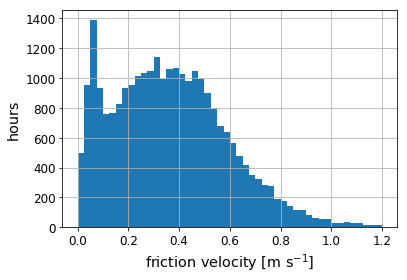

In [28]:
ax = ts['u*'].hist(bins=np.arange(0,1.21,0.025))
plt.tick_params(labelsize='large')
plt.xlabel(r'friction velocity [m s$^{-1}$]',fontsize='x-large')
plt.ylabel(r'hours',fontsize='x-large')

## 4. Calculate surface heat flux $\overline{(\theta'w')}_s$

### - directly from $L \equiv -\frac{u_*^3\bar{\theta}}{\kappa g \overline{(\theta'w')}_s}$

In [29]:
T_at_z = df['thetav'].xs(z,level='height')

In [30]:
Tw = -invL * ts['u*']**3 * T_at_z / (k*g)

In [31]:
Tw.describe()

count    26304.000000
mean         0.138355
std          0.332266
min         -0.304841
25%         -0.021217
50%         -0.000490
75%          0.119393
max          3.266733
dtype: float64

Text(0, 0.5, 'hours')

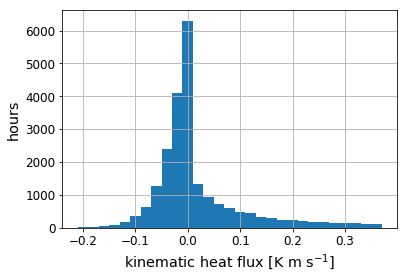

In [32]:
ax = Tw.hist(bins=np.arange(-0.21,0.39,0.02))
plt.tick_params(labelsize='large')
plt.xlabel(r'kinematic heat flux [K m s$^{-1}$]',fontsize='x-large')
plt.ylabel(r'hours',fontsize='x-large')

In [33]:
# follow WRF convention, save heat flux as W/m^2
ts['hfx'] = df['density'].xs(2.0,level='height') * Cp * Tw

### - using WRF similarity function
$\theta(z) - \theta_0 = \frac{\theta_*}{\kappa} (\log(z/z_0) - \psi_h(z/L) + \psi_h(z_0/L))$

$\theta_* \equiv \frac{-\overline{(\theta'w')}_s}{u_*}
= \frac{\kappa(\theta_2 - \theta_1)} {\log(z_2/z_1) - \psi_h(z_2/L) + \psi_h(z_1/L)}$
e.g., as Holtslag2014

Sanity check from the Obukhov stability parameter:
$\frac{z}{L} \equiv \frac{\kappa g z}{\theta_0}\frac{\theta_*}{u_*^2}$

In [34]:
z1,z2 = 2.,10.

In [35]:
T1 = df['thetav'].xs(z1,level='height')
T2 = df['thetav'].xs(z2,level='height')

In [36]:
thetastar = k * (T2-T1) / (np.log(z2/z1) - Jimenez_h(z2*invL) + Jimenez_h(z1*invL))

In [37]:
theta0 = T1 - thetastar/k*(np.log(z1/ts['z0']) - Jimenez_h(z1*invL) + Jimenez_h(ts['z0']*invL))

In [38]:
thetastar.describe()

count    26304.000000
mean        -0.016354
std          3.499548
min       -239.665200
25%         -0.070502
50%          0.042754
75%          0.106196
max         88.732839
Name: thetav, dtype: float64

In [39]:
new_Tw = -thetastar*ts['u*']

In [40]:
new_Tw.describe()

count    26304.000000
mean         0.024751
std          1.654740
min        -42.842242
25%         -0.021824
50%         -0.005734
75%          0.031604
max        126.652900
dtype: float64

Text(0, 0.5, 'hours')

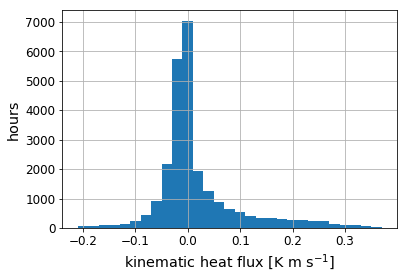

In [41]:
ax = new_Tw.hist(bins=np.arange(-0.21,0.39,0.02))
plt.tick_params(labelsize='large')
plt.xlabel(r'kinematic heat flux [K m s$^{-1}$]',fontsize='x-large')
plt.ylabel(r'hours',fontsize='x-large')

% of all samples binned: [85.05550486618004, 95.5139902676399]


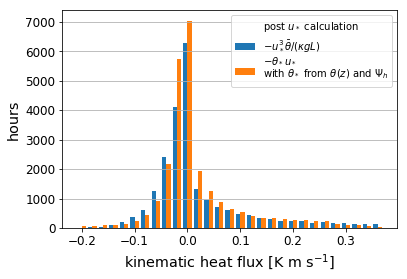

In [42]:
fig,ax = plt.subplots()
counts,bins,patches = ax.hist([Tw,new_Tw], bins=np.arange(-0.21,0.39,0.02))
print('% of all samples binned:',[100*np.sum(cnt)/len(ts) for cnt in counts])

ax.tick_params(labelsize='large')
ax.set_xlabel(r'kinematic heat flux [K m s$^{-1}$]',fontsize='x-large')
ax.set_ylabel(r'hours',fontsize='x-large')
ax.grid(axis='y')
ax.legend([r'$-u_*^3\bar{\theta} / (\kappa g L)$',
           r'$-\theta_* u_*$'+'\n'+r'with $\theta_*$ from $\theta(z)$ and $\Psi_h$'], title=r'post $u_*$ calculation')

#### SANITY CHECK(S)
#### - does calculated $\theta_*$ satisfy the original equations?

In [43]:
LHS = T1 - thetastar/k*(np.log(z1/ts['z0']) - Jimenez_h(z1*invL) + Jimenez_h(ts['z0']*invL))
RHS = T2 - thetastar/k*(np.log(z2/ts['z0']) - Jimenez_h(z2*invL) + Jimenez_h(ts['z0']*invL))
assert np.allclose(LHS, RHS)
assert np.allclose(LHS, theta0)
assert np.allclose(RHS, theta0)

In [44]:
assert np.allclose(np.log(z2/ts['z0']) - np.log(z1/ts['z0']), np.log(z2/z1))

#### <font color='red'>- is the original $z/L$ close to the $z/L$ calculated from $u_*$ and $\theta_*$?</font>
- see notes in Section 2
- see also similar results in `2a-calculate_QOIs_iterative.ipynb`

In [45]:
new_z_L = 2.0*k*g/theta0 * thetastar / ts['u*']**2

Text(0.5, 1.0, '$z/L$')

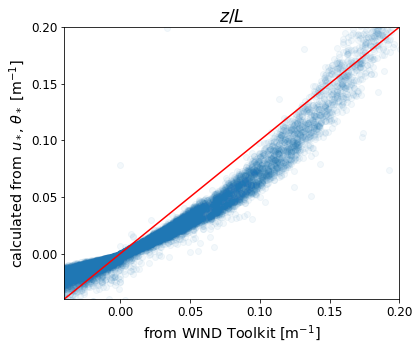

In [46]:
fig,ax = plt.subplots(figsize=(6,5))
ax.scatter(ts['z/L'], new_z_L, alpha=0.05)
minmax = (-0.04, 0.2)
ax.plot(minmax, minmax, 'r')
ax.set_xlim(minmax)
ax.set_ylim(minmax)
ax.tick_params(labelsize='large')
ax.set_xlabel(r'from WIND Toolkit [m$^{-1}$]', fontsize='x-large')
ax.set_ylabel(r'calculated from $u_*$, $\theta_*$ [m$^{-1}$]', fontsize='x-large')
ax.set_title(r'$z/L$', fontsize='xx-large')
#fig.savefig(os.path.join(figdir,'similarity_func_err.png'),bbox_inches='tight')

### 5. Calculate bulk Richardson number

In [47]:
zlow,zhigh = 10., 40.

In [48]:
dz = zhigh - zlow
low = df.xs(zlow,level='height')
high = df.xs(zhigh,level='height')

In [49]:
T0 = df['thetav'].xs(2.0,level='height')

In [50]:
ts['Ri'] = g/T0 * (high['thetav'] - low['thetav']) * dz / (high['windspeed'] - low['windspeed'])**2

### 6. Save new data

In [51]:
ts.head()

,z/L,RH,precipitationrate,GHI,pressure,z0,u*,hfx,Ri
datetime,,,,,,,,,
2011-01-01 00:00:00,-0.005493,76.10568,0.732422,0.0,82520.523438,0.01,0.488319,23.511533,-0.042421
2011-01-01 01:00:00,-0.007324,76.53035,0.732422,0.0,82549.820312,0.01,0.440878,23.079022,-0.047499
2011-01-01 02:00:00,-0.006714,74.86862,0.366211,0.0,82559.890625,0.01,0.440988,21.174711,-0.017757
2011-01-01 03:00:00,-0.006714,76.02008,0.000000,0.0,82550.734375,0.01,0.407729,16.734850,-0.018796
2011-01-01 04:00:00,-0.010987,79.47447,0.732422,0.0,82562.640625,0.01,0.377586,21.750063,-0.031577


In [52]:
%time ts.to_csv(os.path.join(compressed_output,'WTK_ts.calc.csv.gz'), compression='gzip')


CPU times: user 648 ms, sys: 11.5 ms, total: 659 ms
Wall time: 669 ms


In [53]:
df.head()

pressure  temperature  winddirection  windspeed  \
datetime   height                                                        
2011-01-01 2.0     82498.458594   255.697800            NaN        NaN   
           10.0    82410.199219   255.481125     299.963379   8.313240   
           40.0    82079.226562   255.139313     300.045776   9.454636   
           60.0    81858.578125   254.940948     299.974365   9.753716   
           80.0    81637.929688   254.760895     299.842529   9.961243   

                    density      thetav  
datetime   height                        
2011-01-01 2.0     1.123574  255.856046  
           10.0    1.123335  255.716036  
           40.0    1.120337  255.667990  
           60.0    1.118203  255.666316  
           80.0    1.115984  255.683616

In [54]:
%time df.to_csv(os.path.join(compressed_output,'WTK.calc.csv.gz'), compression='gzip')

# CPU times: user 5.59 s, sys: 103 ms, total: 5.69 s
# Wall time: 5.72 s

CPU times: user 5.85 s, sys: 97.1 ms, total: 5.94 s
Wall time: 5.95 s
